### Import required libraries
This tutorial requires some Python core libraries, Numpy, Matplotlib and Flopy. 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

import flopy
from flopy.utils.triangle import Triangle as Triangle

flopy is installed in c:\users\jorge\appdata\local\programs\python\python37\lib\site-packages\flopy


### Define model file path and executables
The folder for the model files and simulation output is defined as well as executables for the triangular mesh generator and Modflow 6.

In [2]:
workspace = '../Model/'
triExeName = '../Exe/triangle.exe'
mf6ExeName = '../Exe/mf6.exe'

### Define domain and drain location
The active model domain is a trapezoid with the smaller parallel side located at the model east side. The drain was conceptualized as a rectangle on the center left part of the model. 

In [3]:
active_domain = [(0, 0), (100, 10), (100, 55), (0, 65)]
drain_domain= [(80, 31), (95, 31), (95, 34), (80, 34)]

### Tringle mesh creation
We use the Triangle tool from the flopy utils that actually implement the Triangle program to generate meshes. This tutorial comes with the Triangle executable for Windows, if you use another operating system it is needed to compile the source code that you can find from https://www.cs.cmu.edu/~quake/triangle.html.

In [4]:
tri = Triangle(angle=30, model_ws=workspace, exe_name=triExeName)
tri.add_polygon(active_domain)
tri.add_polygon(drain_domain)
tri.add_region((10,10),0,maximum_area=30) #coarse discretization
tri.add_region((88,33),1,maximum_area=5) #fine discretization
tri.build()

### Generated triangular grid and boundary representation

The next step is the mesh representation representation and a identification of the boundaries create from the mesh generation

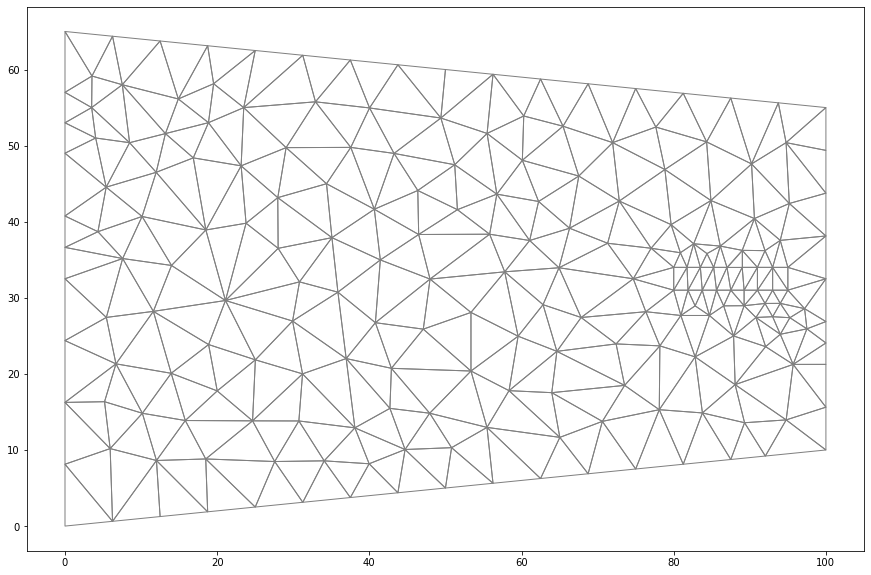

In [5]:
fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1, aspect='equal')
tri.plot(edgecolor='gray')

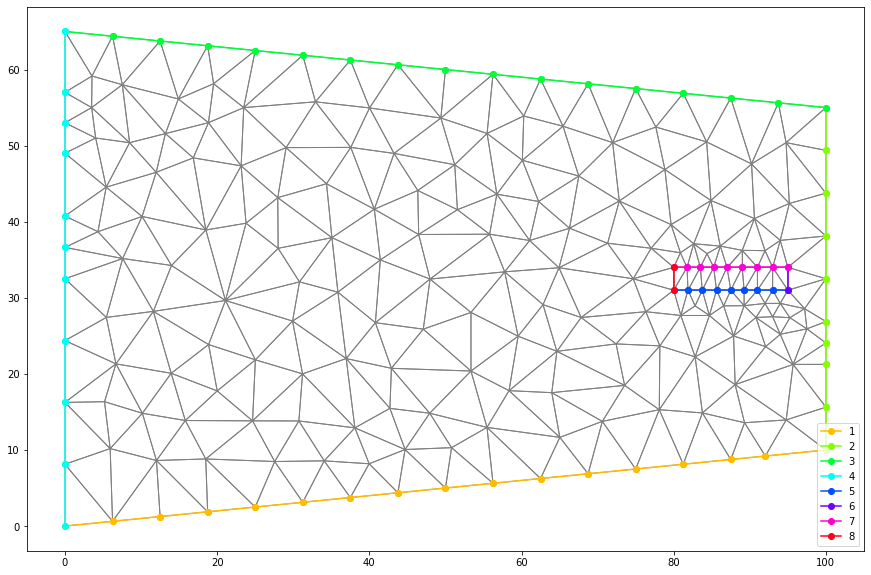

In [6]:
### Indentification and representation of grid boundaries

fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1, aspect='equal')
tri.plot(edgecolor='gray')
numberBoundaries = tri.get_boundary_marker_array().max()+1

cmap = plt.cm.get_cmap("hsv", numberBoundaries)

labelList = list(range(1,numberBoundaries))
i = 0
for ibm in range(1,numberBoundaries):
    tri.plot_boundary(ibm=ibm, ax=ax,marker='o', color=cmap(ibm), label= ibm)
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='lower right')

### Representation of triangle features
By using the available methods for the triangle object "tri" we can represent the vertex and the centroid with their position and label.

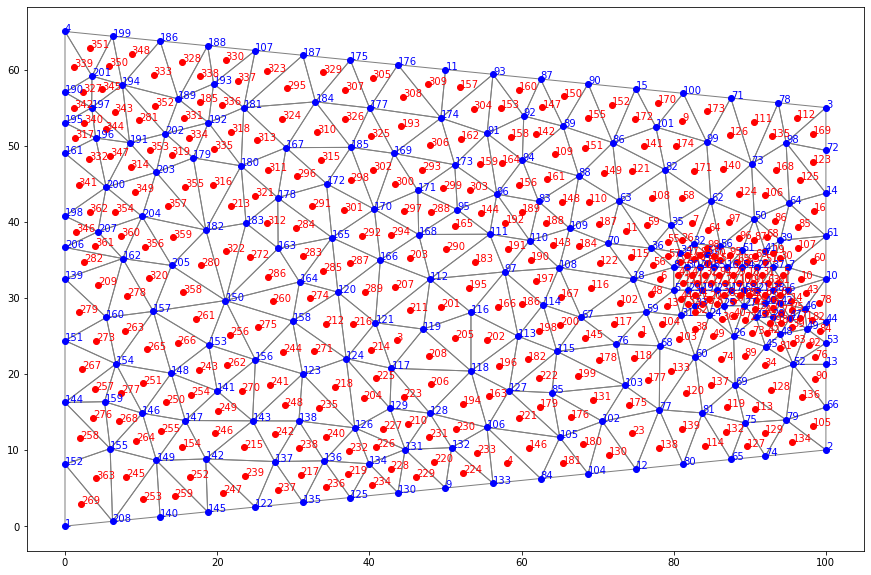

In [7]:
fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1, aspect='equal')
tri.plot(ax=ax, edgecolor='gray')
tri.plot_vertices(ax=ax, marker='o', color='blue')
tri.label_vertices(ax=ax, fontsize=10, color='blue')
tri.plot_centroids(ax=ax, marker='o', color='red')
tri.label_cells(ax=ax, fontsize=10, color='red')

### Configuration of a MODFLOW 6 Model
Once we have the triangular mesh we can create a MODFLOW 6 model. As you might know, MODFLOW 6 has a difference in between a model and a simulation since it implements the concept of exchange in between models. A simulation can have many models, for this case we have a simulation of just one model.

In [8]:
name = 'mf'
sim = flopy.mf6.MFSimulation(sim_name=name, version='mf6',
                             exe_name=mf6ExeName,
                             sim_ws=workspace)
tdis = flopy.mf6.ModflowTdis(sim, time_units='SECONDS',
                             perioddata=[[1.0, 1, 1.]])
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
ims = flopy.mf6.ModflowIms(sim, print_option='SUMMARY', complexity='complex', 
                           outer_hclose=1.e-8, inner_hclose=1.e-8)

### Configuration of the triangular discretization DISV package
MODFLOW 6 differenciates the spatial discretization file and the temporal discretization file. On the spatial discretization options we have three grid types: regular (*.dis), triangular (*.disv) and unstructured (*.disu). This study case uses a triangular discretization. 

In [9]:
cell2d = tri.get_cell2d()
vertices = tri.get_vertices()
xcyc = tri.get_xcyc()
nlay = 1
ncpl = tri.ncpl
nvert = tri.nvert
top = 1.
botm = [0.]

In [10]:
dis = flopy.mf6.ModflowGwfdisv(gwf, length_units='METERS',
                               nlay=nlay, ncpl=ncpl, nvert=nvert,
                               top=top, botm=botm, 
                               vertices=vertices, cell2d=cell2d)

### Configuration of the flow package and the initial conditions

In [11]:
npf = flopy.mf6.ModflowGwfnpf(gwf, k=0.0001)
ic = flopy.mf6.ModflowGwfic(gwf, strt=10.0)

### Definition of the Constant Head CHD boundary conditions 
The left and right sides of the model were defined as CHD boundary condition to represent a regional flow right to left from an hydraulic head of 30m to 10m. See that the edge vertices are obtained from the model grid edges.

In [12]:
chdList = []

leftcells = tri.get_edge_cells(4)
rightcells = tri.get_edge_cells(2)

for icpl in leftcells: chdList.append([(0, icpl), 30])
for icpl in rightcells: chdList.append([(0, icpl), 10])
    
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chdList)

### Definition of the Drain DRN boundary conditions 
At the center left part of the model there is a drain conceptualized as two lines on the border from a previously declared region. The drain has a elevation of 2.5 meters lower that the eastern constant head boundary.

In [13]:
drnList = []

drnCells = tri.get_edge_cells(5) + tri.get_edge_cells(7)

for icpl in drnCells: drnList.append([(0, icpl), 7.5, 0.10])
    
chd = flopy.mf6.ModflowGwfdrn(gwf, stress_period_data=drnList)

### Define output options, write input files and run the model
The tutorial defines the data type that will be stored and the records on the listing file. Then Modflow 6 model files are written on the model folder and simulation is performed.

In [14]:
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord='{}.cbc'.format(name),
                            head_filerecord='{}.hds'.format(name),
                            saverecord=[('HEAD', 'LAST'),
                                        ('BUDGET', 'LAST')],
                            printrecord=[('HEAD', 'LAST'),
                                         ('BUDGET', 'LAST')])

In [15]:
sim.write_simulation()
success, buff = sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model mf...
    writing model name file...
    writing package disv...
    writing package npf...
    writing package ic...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 19 based on size of stress_period_data
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 32 based on size of stress_period_data
    writing package oc...
FloPy is using the following  executable to run the model: ../Exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.3 08/09/2018

   MODFLOW 6 compiled Aug 09 2018 13:40:32 with IFORT compiler (ver. 18.0.3)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigor

### Output data representation
We import the computed heads and represent them on the model extension. A representation of the head equipotential is done by the interpolation of heads at each cell centroid.

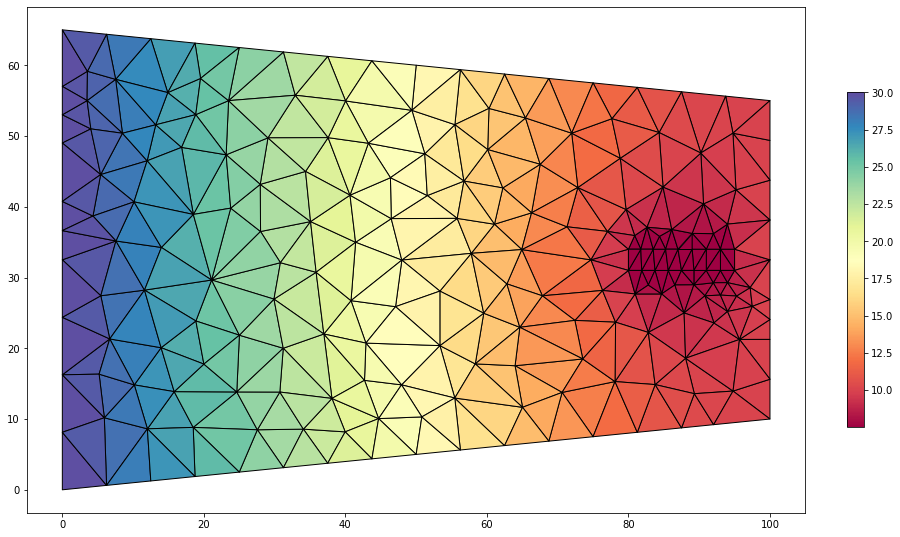

In [16]:
fname = os.path.join(workspace, name + '.hds')
hdobj = flopy.utils.HeadFile(fname, precision='double')
head = hdobj.get_data()

fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1, aspect='equal')
img=tri.plot(ax=ax, a=head[0, 0, :], cmap='Spectral')
fig.colorbar(img, fraction=0.02)

In [17]:
from scipy.interpolate import griddata
x, y = tri.get_xcyc()[:,0],tri.get_xcyc()[:,1]
xG = np.linspace(x.min(),x.max(),100)
yG = np.linspace(y.min(),y.max(),100)
X, Y = np.meshgrid(xG, yG)
z = head[0,0,:]

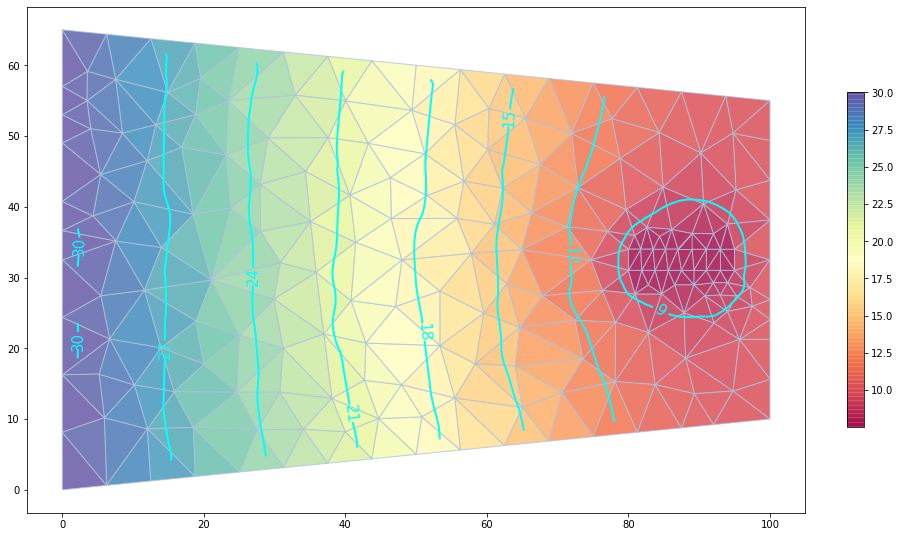

In [18]:
fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1, aspect='equal')
img=tri.plot(ax=ax, edgecolor='lightsteelblue', a=head[0, 0, :], cmap='Spectral', alpha=0.8)
fig.colorbar(img, fraction=0.02)
Ti = griddata((x, y), z, (X, Y), method='cubic')
CS = ax.contour(X,Y,Ti, colors='Cyan', linewidths=2.0)
ax.clabel(CS, inline=1, fontsize=15, fmt='%1.0f')
plt.show()